# Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

### My Imports

In [ ]:
!pip install mega.py
from mega import Mega
mega = Mega()

In [ ]:
file0 = mega.download_url('https://mega.nz/file/Ul4CiChZ#zQvTNBqjFH6zvbgmyWHMKxsiDGStRW-aF1C7Di7SCOk') # dataset
file1 = mega.download_url('https://mega.nz/file/dsIFlDqA#r14XCj5g9lUDNMXS_h6ejwRv8RVK2DKz-onq-BohdH4') # english vectorization layer
file2 = mega.download_url('https://mega.nz/file/RpplSYDZ#60S9hFn2OtJXMmrBRH_VWAqp0-Ch2z1IWc20mfmm3sI') # french layer

# Data Preparation

In [ ]:
text_dataset = tf.data.TextLineDataset(file0)

In [ ]:
for i in text_dataset.take(3):
  print(i)

tf.Tensor(b'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)', shape=(), dtype=string)
tf.Tensor(b'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)', shape=(), dtype=string)
tf.Tensor(b'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)', shape=(), dtype=string)


In [ ]:
# sampled_dataset = text_dataset.take(1000)
# original_dataset = text_dataset
# text_dataset = sampled_dataset

hi


# Data Preprocessing

In [ ]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=300
BATCH_SIZE=64

In [ ]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [ ]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [ ]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [ ]:
split_dataset=text_dataset.map(selector)

In [ ]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [ ]:
init_dataset=text_dataset.map(separator)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


Below commented lines were ran doing training, now the output is already imported from mega

In [ ]:
# english_training_data=init_dataset.map(lambda x,y:x)
# english_vectorize_layer.adapt(english_training_data)

In [ ]:
# french_training_data=init_dataset.map(lambda x,y:y)
# french_vectorize_layer.adapt(french_training_data)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# from tensorflow.keras.models import Sequential

# model = Sequential([english_vectorize_layer])
# model.save('/content/drive/My Drive/dataset/english_vectorize_layer.keras')

# model = Sequential([french_vectorize_layer])
# model.save('/content/drive/My Drive/dataset/french_vectorize_layer.keras')

In [ ]:
from tensorflow.keras.models import load_model

x = load_model(file1)
y = load_model(file2)

In [ ]:
english_vectorize_layer = x.layers[0]
french_vectorize_layer = y.layers[0]

In [ ]:
print(len(english_vectorize_layer.get_vocabulary()))
print(len(french_vectorize_layer.get_vocabulary()))

16952
20000


In [ ]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [ ]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
dataset=split_dataset.map(vectorizer)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[104,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [ ]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [ ]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [ ]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [ ]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [ ]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

# Model

## Encoder

In [ ]:
class Encoder(tf.keras.Model):

  def __init__(self, vocab_size, embedding_dim, units):
    super(Encoder, self).__init__()
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    self.units = units

  def build(self, input_shape):
    self.embedding = Embedding(self.vocab_size, self.embedding_dim)
    self.lstm = LSTM(self.units, return_sequences = True)

  def call(self,x):
    x = self.embedding(x)
    output = self.lstm(x)
    return output

In [ ]:
HIDDEN_UNITS = 256 # NO OF LSTM
EMBEDDING_DIM = 256
encoder = Encoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS)
encoder_output = encoder(tf.zeros([128, 8]))
print(encoder_output.shape)

(128, 8, 256)


## Bahdanau Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.units=units

  def build(self,input_shape):
    self.w_1=tf.keras.layers.Dense(self.units)
    self.w_2=tf.keras.layers.Dense(self.units)
    self.w=tf.keras.layers.Dense(1)

  def call(self,prev_dec_state,enc_states):
    scores=self.w(
        tf.nn.tanh(
        self.w_1(tf.expand_dims(prev_dec_state,-2)) +
        self.w_2(enc_states)))

    attention_weights=tf.nn.softmax(scores,axis=1)
    context_vector=attention_weights*enc_states
    context_vector=tf.reduce_sum(context_vector,axis=1)
    return context_vector,attention_weights

In [ ]:
bahdanau_attention=BahdanauAttention(256)
context_vector,attention_weights=bahdanau_attention(tf.zeros([128,32]),tf.zeros([128,8,32]))
print(context_vector.shape)
print(attention_weights.shape)

(128, 32)
(128, 8, 1)


## Decoder

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,dec_units,sequence_length):
    super(Decoder,self).__init__()
    self.embedding_dim=embedding_dim
    self.vocab_size=vocab_size
    self.dec_units=dec_units
    self.sequence_length=sequence_length

  def build(self,input_shape):
    self.dense=Dense(self.vocab_size,activation="softmax")
    self.gru=GRU(
        self.dec_units,return_sequences=True,return_state=True)
    self.attention=BahdanauAttention(self.dec_units)
    self.embedding=Embedding(self.vocab_size,self.embedding_dim)

  def call(self,x,hidden,shifted_target):
    outputs=[]
    context_vectors=[]
    attention_weights=[]
    shifted_target=self.embedding(shifted_target)

    for t in range(0,self.sequence_length):
      context_vector,attention_weights=self.attention(hidden,x)
      dec_input=context_vector+shifted_target[:,t]
      output,hidden=self.gru(tf.expand_dims(dec_input,1))
      outputs.append(output[:,0])

    outputs=tf.convert_to_tensor(outputs)
    outputs=tf.transpose(outputs, perm=[1,0,2])

    outputs=self.dense(outputs)
    return outputs,attention_weights

In [ ]:
decoder=Decoder(VOCAB_SIZE,EMBEDDING_DIM,HIDDEN_UNITS,FRENCH_SEQUENCE_LENGTH)
outputs,attention_weights=decoder(encoder_output,tf.zeros([128,HIDDEN_UNITS]),tf.zeros([128,64]))
print(outputs.shape)
print(attention_weights.shape)

(128, 64, 20000)
(128, 8, 1)


In [ ]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
encoder=Encoder(VOCAB_SIZE,EMBEDDING_DIM,HIDDEN_UNITS)
encoder_output=encoder(input)

### DECODER
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
decoder=Decoder(VOCAB_SIZE,EMBEDDING_DIM,HIDDEN_UNITS,FRENCH_SEQUENCE_LENGTH)
decoder_output,attention_weightss=decoder(encoder_output,tf.zeros([1,HIDDEN_UNITS]),shifted_target)

### OUTPUT
bahdanau=Model([input,shifted_target],decoder_output)
bahdanau.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_5 (Encoder)       │ (None, 64, 256)        │      5,645,312 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_2 (InputLayer)      │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_5 (Decoder)       │ [(None, 64, 20000),    │     10,786,593 │ encoder_5[0][0],       │
│                           │ (None, 64, 1)]         │                │ input_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,431,905 (62.68 MB)

 Trainable params: 16,431,905 (62.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [ ]:
bahdanau.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),
    metrics=[BLEU()],
    run_eagerly=True)

In [ ]:
history=bahdanau.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
1405/1405 [==============================] - 365s 237ms/step - loss: 5.4511 - val_loss: 4.7071
Epoch 2/10
1405/1405 [==============================] - 213s 151ms/step - loss: 3.3392 - val_loss: 3.7340
Epoch 3/10
1405/1405 [==============================] - 211s 149ms/step - loss: 2.6036 - val_loss: 3.3412
Epoch 4/10
1405/1405 [==============================] - 208s 148ms/step - loss: 2.1854 - val_loss: 3.0057
Epoch 5/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.9171 - val_loss: 2.8613
Epoch 6/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.7524 - val_loss: 2.7807
Epoch 7/10
1405/1405 [==============================] - 209s 148ms/step - loss: 1.6374 - val_loss: 2.7714
Epoch 8/10
1405/1405 [==============================] - 207s 147ms/step - loss: 1.5560 - val_loss: 2.7180
Epoch 9/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.4913 - val_loss: 2.7244
Epoch 10/10
1405/1405 [=======================

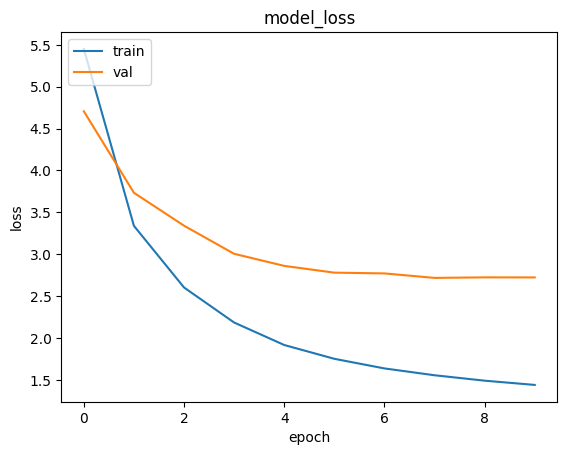

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
bahdanau.evaluate(val_dataset)

375/375 [==============================] - 53s 46ms/step - loss: 2.7233


2.7233364582061768

# Testing

In [ ]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [ ]:
word_to_index={y:x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=bahdanau.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('What makes you think that is not true?')

'questce qui te fait croire que ce nest pas vrai'

In [ ]:
translator('Have you ever watched a soccer under the rain?')

'astu déjà regardé un match de la pluie'

In [ ]:
translator('Great trees do not grow with ease, the stronger the winds, the stronger the trees')

'des arbres sont très [UNK] pas fort'

In [ ]:
translator('Everyone should water his or her tomato plants')

'tout le monde devrait manger sa propriété à la nage'